In [2]:
import numpy as np
import random
import math
import heapq
import ray
from benchmark_parser import bg_parser, parser
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gym.spaces import Discrete, MultiDiscrete, Dict
from ray import tune, air
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.agents.ppo import PPOTrainer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env
from my_env import RtGridEnv, MultiEnv, SwitchBenchmarkCallback, PrintEnvCallback, AStar
from ray.rllib.algorithms.callbacks import DefaultCallbacks

In [119]:
astar_re = []
astar_wl = []
rl_re = []
rl_wl = []

In [69]:
length, width, capacity, nets = bg_parser("/home/brucexi2/DQN_GlobalRouting/GlobalRoutingRL/benchmark/test_benchmark_23.gr")
edge_capacity = np.full((length,width,4),capacity)
macros = []
env = RtGridEnv(length, width, nets, macros, edge_capacity)
astar_env = AStar(length, width, nets, macros, edge_capacity)

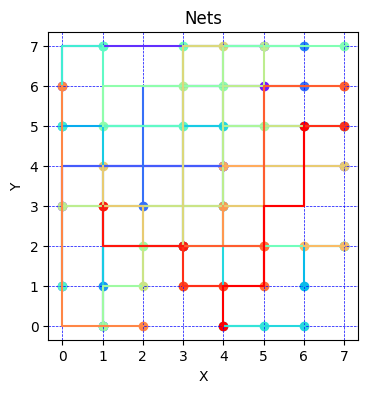

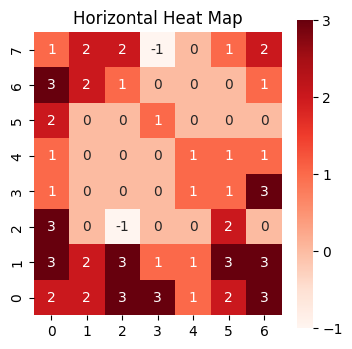

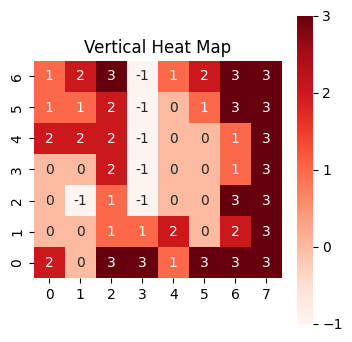

3332
203


In [70]:
# A* routing
astar_env.route()
astar_env.render(2)
astar_env.heatmap(2)
print(astar_env.total_reward)
print(astar_env.wirelength)
#astar_re.append(astar_env.total_reward)
#astar_wl.append(astar_env.wirelength)

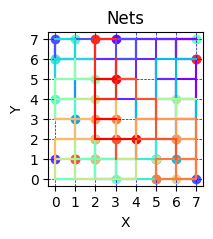

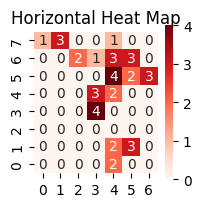

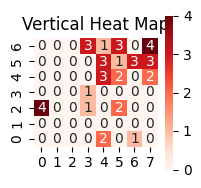

In [8]:
# render the env
num_episodes = 1

for ep in range(num_episodes):
    obs = env.reset()
    done = {}
    for i in range(len(nets)):
        done["agent_{}".format(i)] = False
    done["__all__"] = False
    while True:
        action = env.random_action()
        # only agents that are not done will be provided an action
        action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
        new_obs, reward, done, info = env.step(action)

        if done["__all__"]:
            break

    env.render()
    env.heatmap()


In [55]:
# check the environment
register_env("routing_grid_env", lambda config: RtGridEnv(length, width, nets, macros, edge_capacity))
env = RtGridEnv(length, width, nets, macros, edge_capacity)

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

checking environment ...
All checks passed. No errors found.


In [49]:
# config everything
config = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1  #any number here will be reset = 1 for DQN
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
    .training(clip_param=tune.grid_search([0.1, 0.2, 0.3, 0.4]),  # Added this line for clipping parameter
        vf_loss_coeff=tune.loguniform(1e-4, 1e-1))
)

stop_criteria = dict(training_iteration = 60)
tuner = tune.Tuner(
    config.algo_class,
    param_space = config.to_dict(),
    run_config = air.RunConfig(
        local_dir = "prmt_tuning/{}".format("23"),
        stop = stop_criteria,
        verbose = 2,
        checkpoint_config=air.CheckpointConfig(checkpoint_at_end=True)
    )
)

In [50]:
experiment_results = tuner.fit()

2023-10-07 18:55:28,108	INFO tune.py:887 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2023-10-07 18:55:29,791	INFO worker.py:1538 -- Started a local Ray instance.


(raylet) /home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/dashboard/agent.py:51: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(PPO pid=139984) 2023-10-07 18:55:34,145	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=139984) 2023-10-07 18:55:34,652	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=140040) 2023-10-07 18:55:38,811	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=140147) 2023-10-07 18:55:43,485	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make 

Trial name,agent_timesteps_total,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,evaluation,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,timers
PPO_routing_grid_env_c2a6d_00000,2826176,"{'num_env_steps_sampled': 2826176, 'num_env_steps_trained': 2826176, 'num_agent_steps_sampled': 2826176, 'num_agent_steps_trained': 2826176}",{},30.2761,{},3342,3254.07,2899,134,"{'episode_reward_max': 3198.0, 'episode_reward_min': 3198.0, 'episode_reward_mean': 3198.0, 'episode_len_mean': 50.0, 'episode_media': {}, 'episodes_this_iter': 5, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [3198.0, 3198.0, 3198.0, 3198.0, 3198.0], 'episode_lengths': [50, 50, 50, 50, 50]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 1.2514468616978482, 'mean_inference_ms': 0.8419556829265652, 'mean_action_processing_ms': 0.09136515493389502, 'mean_env_wait_ms': 0.18814085220407256, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'num_agent_steps_sampled_this_iter': 1180, 'num_env_steps_sampled_this_iter': 1180, 'timesteps_this_iter': 1180, 'num_healthy_workers': 2, 'num_in_flight_async_reqs': 0, 'num_remote_worker_restarts': 0}","{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.6094863570114184, 'cur_kl_coeff': 3.4694469519536144e-19, 'cur_lr': 5.0000000000000016e-05, 'total_loss': -0.004467063975106511, 'policy_loss': -0.006045683417210563, 'vf_loss': 9.593638009097841, 'vf_explained_var': 0.008680039238598612, 'kl': 0.0016030022192840556, 'entropy': 0.3122639255080786, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 657810.5, 'diff_num_grad_updates_vs_sampler_policy': 3599.5}}, 'num_env_steps_sampled': 2826176, 'num_env_steps_trained': 2826176, 'num_agent_steps_sampled': 2826176, 'num_agent_steps_trained': 2826176}",2826176,2826176,2826176,30793,2826176,30793,0,2,0,0,30793,"{'cpu_util_percent': 16.59423076923077, 'ram_util_percent': 82.47692307692306}",{},{},{},"{'mean_raw_obs_processing_ms': 2.0503776364279873, 'mean_inference_ms': 0.7831665560473419, 'mean_action_processing_ms': 0.132256403536385, 'mean_env_wait_ms': 0.2138496260538353, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 3342.0, 'episode_reward_min': 2899.0, 'episode_reward_mean': 3254.0671641791046, 'episode_len_mean': 30.276119402985074, 'episode_media': {}, 'episodes_this_iter': 134, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [3173.0, 3324.0, 3180.0, 3194.0, 3336.0, 3329.0, 2899.0, 3198.0, 3057.0, 3330.0, 3199.0, 3321.0, 3340.0, 3337.0, 3181.0, 3312.0, 3306.0, 3048.0, 3341.0, 3339.0, 3182.0, 3337.0, 3333.0, 3342.0, 3318.0, 3309.0, 3314.0, 3321.0, 3311.0, 3332.0, 3326.0, 3191.0, 3195.0, 3311.0, 3320.0, 3330.0, 3328.0, 3195.0, 3187.0, 3326.0, 3338.0, 3180.0, 3187.0, 3184.0, 3327.0, 3192.0, 3336.0, 2912.0, 3307.0, 3055.0, 3336.0, 3337.0, 3045.0, 3033.0, 3321.0, 3195.0, 3323.0, 3331.0, 3307.0, 3196.0, 3315.0, 3332.0, 3040.0, 3319.0, 3197.0, 3197.0, 3326.0, 3338.0, 3340.0, 3337.0, 3333.0, 3338.0, 3337.0, 3048.0, 3051.0, 3190.0, 3334.0, 3329.0, 3322.0, 3318.0, 3192.0, 3333.0, 3197.0, 3187.0, 3182.0, 3194.0, 3324.0, 3195.0, 3316.0, 3328.0, 3333.0, 3322.0, 3179.0, 3199.0, 3325.0, 3330.0, 3322.0, 3333.0, 3336.0, 3327.0, 3336.0, 3338.0, 3153.0, 3196.0, 3033.0, 3341.0, 3340.0, 2901.0, 3334.0, 3199.0, 3330.0, 3319.0, 3335.0, 3331.0, 3319.0, 3172.0, 2907.0, 3052.0, 3328.0, 3330.0, 3314.0, 3329.0, 3191.0, 3333.0,

(PPO pid=144695) 2023-10-07 19:54:07,489	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=144695) 2023-10-07 19:54:08,021	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=144750) 2023-10-07 19:54:11,732	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=144854) 2023-10-07 19:54:15,847	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(PPO pid=144695) 2023-10-07 19:54:16,055	WARNING util.py:6

,experiment_id,config/lr,config/gamma,episode_reward_mean,hist_stats/episode_reward
0,0d92eb6d206a48a88cb116b10caf8fc7,0.00005,0.99,2586.12,"[2470.0, 2753.0, 2611.0, 2468.0, 2594.0, 2465...."
1,4ae09412ef4842c5ad6eab649761d365,0.00010,0.99,2776.45,"[3017.0, 2607.0, 2318.0, 2889.0, 2603.0, 2888...."
2,d9c2b61a8e1c4c3dbecee7a9319a5d75,0.00015,0.99,2962.84,"[3014.0, 3165.0, 2990.0, 2749.0, 2885.0, 3146...."
3,825c0d0a1ea143449e6ee83c7d9d9351,0.00020,0.99,2923.85,"[3022.0, 2888.0, 2745.0, 3018.0, 3028.0, 3029...."
4,459ec90e3a4f4305964cc9a1e6a43242,0.00025,0.99,2979.31,"[2898.0, 3178.0, 3181.0, 2893.0, 3183.0, 3040...."


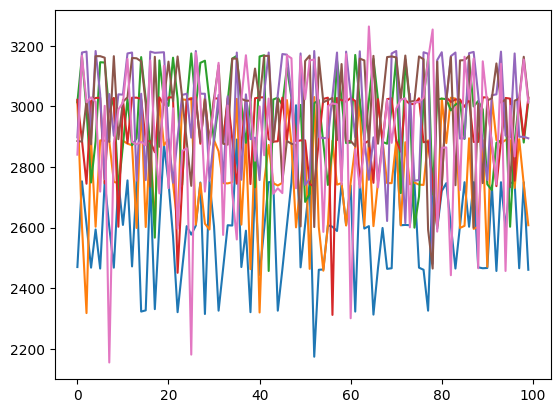

In [276]:
# extract the training results
df = experiment_results.get_dataframe()
temp_column = ["experiment_id",  "config/lr", "config/gamma", "episode_reward_mean", "hist_stats/episode_reward"]
temp = df.loc[:, temp_column].head()
from IPython.display import display
display(temp)

lr = df["config/lr"].tolist()
reward = df["hist_stats/episode_reward"].tolist()
#print(type(reward[0]))
import ast
#print(ast.literal_eval(reward[0]))
#reward = [[int(item) for item in sublist] for sublist in reward]
#print(reward)
for i in range(len(lr)):
    plt.plot(ast.literal_eval(reward[i]), label=lr[i])

plt.show()


In [56]:
checkpoint = "/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/prmt_tuning/23/PPO_2023-10-07_18-55-24/PPO_routing_grid_env_c2a6d_00003_3_clip_param=0.4000,vf_loss_coeff=0.0006_2023-10-07_21-33-28/checkpoint_000060"
config_inf = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1  #any number here will be reset = 1 for DQN
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
)
algo = config_inf.build()
algo.restore(checkpoint)

(RolloutWorker pid=606327) 2023-10-08 08:13:30,206	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=606415) 2023-10-08 08:13:34,340	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-10-08 08:13:34,599	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-10-08 08:13:34,635	INFO trainable.py:790 -- Restored on 10.0.0.82 from checkpoint: /home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/prmt_tuning/23/PPO_2023-10-07_18-55-24/PPO_routing_grid_env_c2a6d_00003_3_clip_param=0.4000,vf_loss_coeff=0.0006_2023-10-07_21-33-28/checkpoint_000060
2023-10-08 08:13:34,6

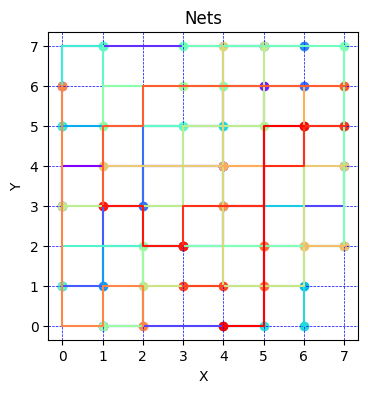

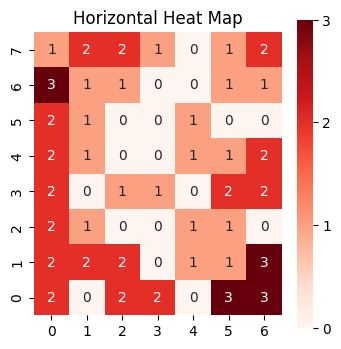

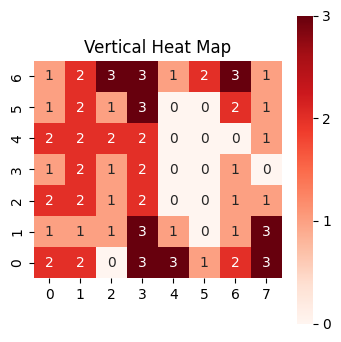

3340
195


In [67]:
num_episodes = 1
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = {}
    for i in range(len(nets)):
        done["agent_{}".format(i)] = False
    done["__all__"] = False
    while True:
        action = algo.compute_actions(observations=obs, explore=False)
        # only agents that are not done will be provided an action
        action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
        obs, reward, done, info = env.step(action)
        total_reward += sum(reward.values())

        if done["__all__"]:
            break
env.render(2)
env.heatmap(2)
print(total_reward)
print(env.wirelength)
#rl_re.append(total_reward)
#rl_wl.append(env.wirelength)

In [33]:
model = algo.get_policy().model

# Print the model architecture
print(model)

FullyConnectedNetwork(
  (_logits): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=48, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=48, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)


In [53]:
algo.stop()
ray.shutdown()

In [280]:
#astar_re = []
#astar_wl = []
#rl_re = []
#rl_wl = []
all_rewards = []
for i in [12]:
    rewards = []
    length, width, capacity, nets = bg_parser("/home/brucexi2/DQN_GlobalRouting/GlobalRoutingRL/benchmark/test_benchmark_{}.gr".format(i))
    edge_capacity = np.full((length,width,4),capacity)
    macros = []
    #env = RtGridEnv(length, width, nets, macros, edge_capacity)
    astar_env = AStar(length, width, nets, macros, edge_capacity)
    # A* routing
    astar_env.route()
    #astar_env.render()
    #astar_env.heatmap()
    astar_re.append(astar_env.total_reward)
    astar_wl.append(astar_env.wirelength)
    # check the environment
    register_env("routing_grid_env", lambda config: RtGridEnv(length, width, nets, macros, edge_capacity))
    env = RtGridEnv(length, width, nets, macros, edge_capacity)

    print("checking environment ...")
    try:
        check_env(env)
        print("All checks passed. No errors found.")
    except:
        print("failed")
        print(check_env(env))
    # config everything
    config = (
        PPOConfig()
        .environment(env = "routing_grid_env")
        .framework(framework="torch")
        .evaluation(
            evaluation_interval=15, 
            evaluation_duration=5,      
            evaluation_num_workers=2,  #0 for Colab
            evaluation_parallel_to_training=True, #False for Colab
            evaluation_config = dict(
                explore=False,
                num_workers=1  #any number here will be reset = 1 for DQN
            ))
        .rollouts(
        num_rollout_workers=2, #1 for Colab
        num_envs_per_worker=1)
        .training(lr=0.0005)
    )
    algo = config.build()
    checkpoint_dir = "prmt_tuning/{}".format(i)

    for j in range(50):
        result = algo.train()
        rewards.append(result["episode_reward_mean"])
    checkpoint_file = algo.save(checkpoint_dir)

    num_episodes = 1
    for ep in range(num_episodes):
        total_reward = 0
        obs = env.reset()
        done = {}
        for i in range(len(nets)):
            done["agent_{}".format(i)] = False
        done["__all__"] = False
        while True:
            action = algo.compute_actions(observations=obs, explore=False)
            # only agents that are not done will be provided an action
            action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
            obs, reward, done, info = env.step(action)
            total_reward += sum(reward.values())

            if done["__all__"]:
                break
    #env.render()
    #env.heatmap()
    rl_re.append(total_reward)
    rl_wl.append(env.wirelength)

    algo.stop()
    ray.shutdown()
    all_rewards.append(rewards)

checking environment ...
All checks passed. No errors found.


(RolloutWorker pid=176662) 2023-10-02 09:36:15,195	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-10-02 09:36:18,951	WARNING util.py:66 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=176750) 2023-10-02 09:36:18,939	WARNING env.py:247 -- Your MultiAgentEnv <RtGridEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=176662) 2023-10-02 09:36:25,315	WARNING simple_list_collector.py:197 -- More than 21061 observations in 650 env steps for episode 106472242606223071 are buffered in the sampler. If this is more than you expected, check that that you set a horizon on your environment correctly and that it termin

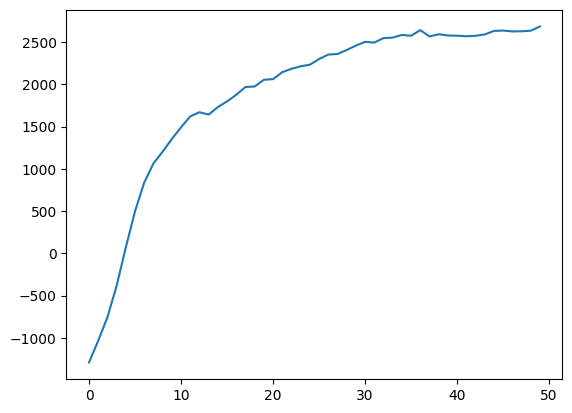

In [281]:
plt.plot(all_rewards[0])
plt.show()
#plt.plot(all_rewards[1])
#plt.show()

In [232]:
# fine tuning
for j in range(10):
    result = algo.train()
    num_episodes = 1
    for ep in range(num_episodes):
        total_reward = 0
        obs = env.reset()
        done = {}
        for i in range(len(nets)):
            done["agent_{}".format(i)] = False
        done["__all__"] = False
        while True:
            action = algo.compute_actions(observations=obs, explore=False)
            # only agents that are not done will be provided an action
            action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
            obs, reward, done, info = env.step(action)
            total_reward += sum(reward.values())

            if done["__all__"]:
                break
    #env.render()
    #env.heatmap()
    print(total_reward)
    print(env.wirelength)
    checkpoint_file = algo.save("prmt_tuning/{}".format(5))
    print(result["episode_reward_mean"])


3384
151
3368.4448398576515
3384
151
3366.696296296296
3384
151
3360.7023809523807
3384
151
3360.18992248062
3384
151
3375.006230529595
3384
151
3363.580291970803
3384
151
3354.4455445544554
3384
151
3368.709433962264
3384
151
3362.730923694779
3384
151
3346.5124378109454
